<a href="https://colab.research.google.com/github/josedanielisidororeyes/Anal-tica-Descriptiva-y-Predictiva/blob/main/Bayesian_Networks_for_Oil_Markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hmmlearn
!pip install pgmpy
!pip install eia-python
!pip install fredapi
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 33.0 MB/s eta 0:00:00


##Proyect: 1
##Course: 660 Risk Management
##Student Group: 11165
## Team Members:
*   Jose Daniel Isidoro Reyes


# Data Retrieval

In [3]:
#==============================
#  Data Retrieval from EIA
#==============================
import requests
import pandas as pd
import yfinance as yf

# Credentials
API_KEY  = 'UIVpx3G7SbLrbehMusXRE8almeu3EuBpUHuKfFGz'

# Series from EIA
variables = {
    'STEO.RGDPQ_NONOECD.M':   'Real_GDP_NonOECD_Forecast',
    'STEO.RGDPQ_OECD.M':      'Real_GDP_OECD_Forecast',
    'STEO.PAPR_NONOPEC.M':    'Petroleum_Production_NonOPEC',
    'STEO.PAPR_OPEC.M':       'Petroleum_Production_OPEC',
    'STEO.PATC_OECD.M':       'Petroleum_Consumption_OECD',
    'STEO.PATC_NON_OECD.M':   'Petroleum_Consumption_NonOECD',
    'STEO.COPRPUS.M':         'Crude_Oil_Price_WTI_US',
    'STEO.CORIPUS.M':         'Crude_Oil_Price_Brent_Intl',
    'PET.MCRIMXX2.M':         'US_Crude_Oil_Imports',
    'STEO.FOREX_WORLD.M':     'World_Forex_USD_Value',
    'STEO.PASC_OECD_T3.M':    'Petroleum_Supply_Balance_OECD',
    'STEO.COPS_OPEC.M':       'Crude_Oil_Production_OPEC',
    'STEO.COPC_OPEC.M':       'Crude_Oil_Production_Capacity_OPEC',
    'STEO.T3_STCHANGE_OOECD.M': 'Stock_Change_OECD',
    'STEO.T3_STCHANGE_NOECD.M': 'Stock_Change_NonOECD'
}


# Function for data retrieval from EIA
def get_eia_data_cleaned(series_id):
  url = f"https://api.eia.gov/v2/seriesid/{series_id}?api_key={API_KEY}"
  r =  requests.get(url).json()
  if "response" in r and "data" in r["response"]:
    df =  pd.DataFrame(r["response"]["data"])
    df["series_id"] =  series_id
    return df
  else:
    print(f"Error retrieving {variables}")


results  =  [get_eia_data_cleaned(sid) for sid in variables]
eia_data =  pd.concat(results,  ignore_index  =  True)
eia_data =  eia_data[['period', "series_id", "value"]]

# Cleaning variable names
eia_data["series_id"] =  eia_data["series_id"].map(variables)

# Converting period to datetime
eia_data['period'] =  pd.to_datetime(eia_data["period"], format =  "%Y-%m")

# Selecting 20 years of data | 2005-01-01 to 2025-01-01
eia_data =  eia_data[(eia_data["period"] >= "2005-01-01") & (eia_data["period"] <= "2025-01-01")]

# Pivoting variables from rows to columns
eia_data =  eia_data.pivot(index = "period", columns  = "series_id", values  = "value")

# Setting the index for time series manipulation
eia_data.index = pd.to_datetime(eia_data.index)
eia_data.columns.name  =  None


#==========================
#  Data Retrieval from FRED
#==========================

from fredapi import Fred

API_KEY = "3e8ec52b4631b06d5c829014673e84ef"
fred = Fred(api_key=API_KEY)

fred_series  = {
    # Macroeconomic Variable
     "GDP": "Nominal_GDP",
    "GDPC1": "Real_GDP",
    "UNRATE": "Unemployment_Rate",
    # U.S. Energy/Industry Variables
    "CPIENGSL": "CPI_Energy_US",
    "CAPG211S": "Capacity_OilGas_Mining",
    "CAPUTLG211S": "Capacity_Utilization_Mfg_Mining_Util",
    "IPG211S": "Industrial_Production_OilGas_Mining",
    "IPG211111CN": "Industrial_Production_CrudePetroleum",
    "INDPRO": "Industrial_Production_Total",
    "IPN213111N": "Industrial_Production_Drilling_Wells",
    "PCU211211": "Producer_Price_OilGas_Extraction"
}

# Retrieving data from FRED_
df_fred  = pd.DataFrame()
for serie, name in fred_series.items():
  df_fred[name] =  fred.get_series(serie, observation_start= "2005-01-01", observation_end= "2025-01-01")

# Resampling to monthly frequency using backward-fill
df_fred =  df_fred.resample("MS").first().ffill()
df_fred.head()



#==================================
# Data Retrieval from Yahoo Finance
#==================================


financial_data = {
    # --- Energy & Benchmarks ---
    'CL=F': 'WTI_Crude',

    # --- Key Macro & Financial Indicators ---
    '^GSPC': 'SP500',
    '^VIX': 'VIX_Fear_Index',
    'DX=F': 'Dollar_Index_DXY',

    # --- Cross-Commodity & Industrial Demand Signals ---
    'GC=F': 'Gold',
    'SI=F': 'Silver',
    'HG=F': 'Copper_Industrial',

    # --- Fixed Income Proxy (Yields/Policy Expectations) ---
    '^TNX': 'Yield_10Y_Treasury',
    '^TYX': 'Yield_30Y_Treasury',
}

df_f =  yf.download(list(financial_data.keys()), start="2005-01-01", end="2025-01-01")["Close"]

# Renaming columns
df_f.rename(columns  =  financial_data, inplace  =  True)

# Resampling data to monthly frequency
df_f =  df_f.resample('MS').first()


current_p_oil = pd.DataFrame(fred.get_series('WTISPLC'), columns  = ['Oil_Current_Price'])
oil_forecast =  pd.DataFrame(fred.get_series("WTISPLC").shift(-1), columns = ['Oil_Forecast_Price'])
oil_prices  =  pd.concat([current_p_oil, oil_forecast], axis  =  1)
oil_prices = oil_prices.loc["2005-01-01": "2025-01-01"]

# Resampling oil prices to monthly frecuency
oil_prices=  oil_prices.resample("MS").first()
oil_prices


data  = pd.concat([eia_data, df_fred, df_f, oil_prices], axis  =  1, join  =  "inner")
data.head()

/tmp/ipython-input-932151892.py:124: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_f =  yf.download(list(financial_data.keys()), start="2005-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  9 of 9 completed


,Crude_Oil_Price_Brent_Intl,Crude_Oil_Price_WTI_US,Crude_Oil_Production_Capacity_OPEC,Crude_Oil_Production_OPEC,Petroleum_Consumption_NonOECD,Petroleum_Consumption_OECD,Petroleum_Production_NonOPEC,Petroleum_Production_OPEC,Petroleum_Supply_Balance_OECD,Stock_Change_NonOECD,...,Dollar_Index_DXY,Gold,Copper_Industrial,Silver,SP500,Yield_10Y_Treasury,Yield_30Y_Treasury,VIX_Fear_Index,Oil_Current_Price,Oil_Forecast_Price
2005-01-01,15.254225,5.446159,29.823197,1.11,33.793570,50.623522,51.844441,32.766443,2590.245,0.419434,...,81.410004,428.700012,1.5235,6.477,1202.079956,4.220,4.817,14.08,46.84,47.97
2005-02-01,15.142000,5.501359,29.916292,1.11,34.282069,52.294045,52.118935,32.887686,2574.258,1.082207,...,83.470001,420.799988,1.4510,6.720,1189.410034,4.136,4.592,12.03,47.97,54.31
2005-03-01,15.214225,5.600835,30.050681,1.06,34.126744,51.975108,52.084754,33.046153,2555.539,0.565075,...,82.760002,432.899994,1.4645,7.229,1210.410034,4.372,4.721,12.04,54.31,53.04
2005-04-01,15.493533,5.562827,30.007578,0.91,33.959430,49.190263,52.368700,33.222360,2597.164,-0.929533,...,84.400002,425.899994,1.4925,6.990,1172.920044,4.451,4.729,14.09,53.04,49.83
2005-05-01,15.905258,5.596478,30.066666,1.11,33.666841,48.674739,52.786425,33.094697,2677.273,-0.888993,...,84.449997,429.500000,1.4960,6.840,1162.160034,4.194,4.516,15.12,49.83,56.26


# Dependency and Causality Analysis

## Correlation Analysis

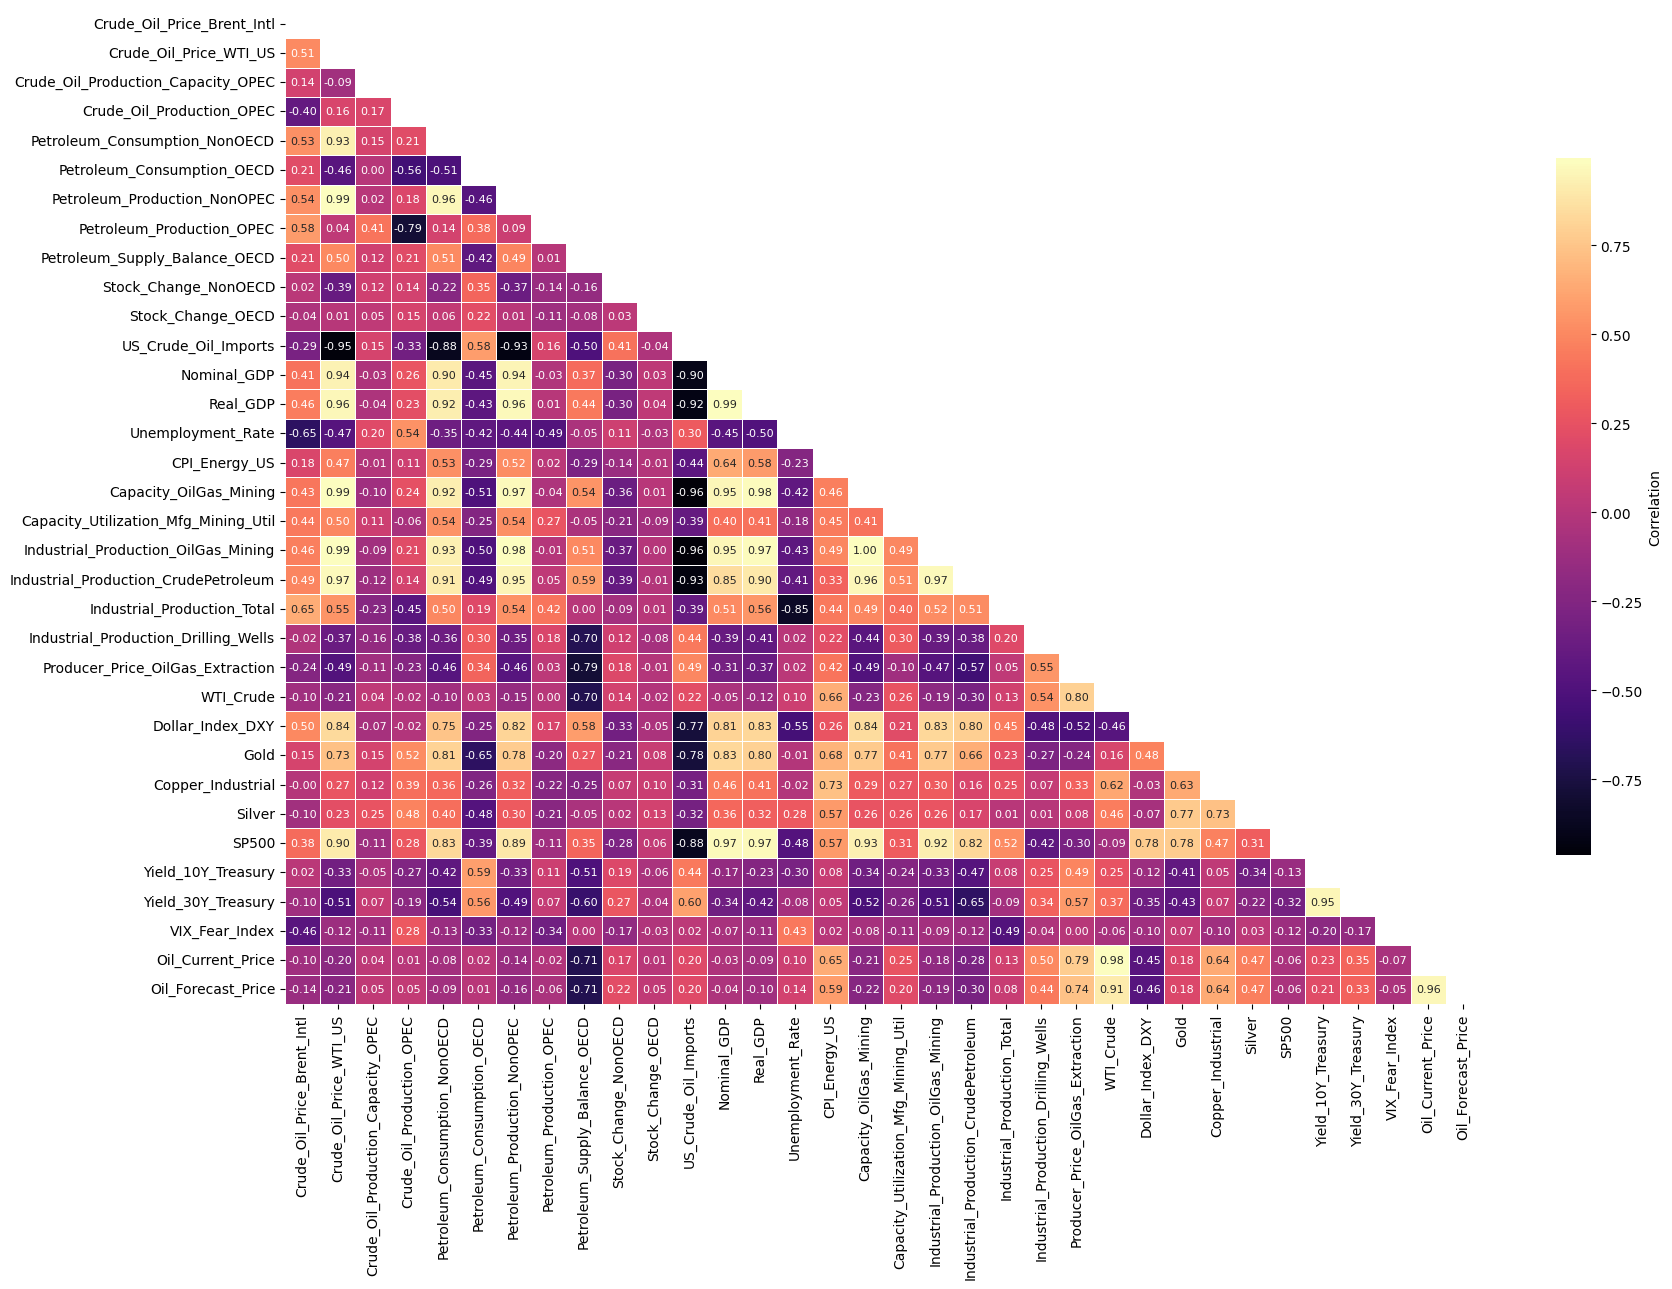

In [4]:
import matplotlib.pyplot as  plt
import numpy as np
import seaborn as sns

corr =  data.corr()
mask =  np.triu(np.ones_like(corr, dtype  = bool))

plt.figure(figsize =  (18, 13))
sns.heatmap(corr,
            mask = mask,
            cmap  = "magma",
            annot =  True,
            fmt  =  ".2f",
            linewidths   =  0.5,
            center =  0,
            cbar_kws =  {'label': 'Correlation', 'shrink': 0.7},
            annot_kws =  {'size': 8})

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## Granger-Test

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

# =================================================================
# Dependency and Causality Analysis for Bayesian Network Structure
# =================================================================

from statsmodels.tsa.stattools import grangercausalitytests

# Data Preparation
data_est =  data.pct_change().dropna()

data_est =  data.pct_change().dropna()

# Function for Granger Tests
def best_granger_pvalue(data, effect_col, cause_col, max_lag=3):
    """
    Granger Causatility Test for 3 lags
    It returns the most significant p-value found
    """
    try:
        df_test = data[[effect_col, cause_col]].dropna()
        results = grangercausalitytests(df_test, max_lag, verbose=False)
        p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        return min(p_values)
    except Exception:
        # Captura el 'InfeasibleTestError' y devuelve np.nan
        return np.nan

# Test Configuration
target_variable = "Oil_Current_Price"
max_lag = 3
significance_level = 0.05

other_vars = [col for col in data_est.columns if col != target_variable]

print(f"--- Variables that predict {target_variable} (p < {significance_level})---")

# Bucle principal para probar cada variable
for var in other_vars:

    # Llama a tu función, que maneja los errores
    best_p_value = best_granger_pvalue(data_est, target_variable, var, max_lag)

    # Revisa si el p-value es significativo (esto está ahora DENTRO del bucle)
    if best_p_value < significance_level:
        print(f"Variable: {var} (Minimum P-Value: {best_p_value:.6f})")

print("\n--- End of analysis ---")


--- Variables that predict Oil_Current_Price (p < 0.05)---
Variable: Crude_Oil_Production_Capacity_OPEC (Minimum P-Value: 0.011112)
Variable: Petroleum_Consumption_NonOECD (Minimum P-Value: 0.000332)
Variable: Petroleum_Consumption_OECD (Minimum P-Value: 0.000453)
Variable: Petroleum_Production_NonOPEC (Minimum P-Value: 0.000526)
Variable: Petroleum_Production_OPEC (Minimum P-Value: 0.010286)
Variable: Nominal_GDP (Minimum P-Value: 0.000008)
Variable: Real_GDP (Minimum P-Value: 0.000001)
Variable: Unemployment_Rate (Minimum P-Value: 0.000000)
Variable: CPI_Energy_US (Minimum P-Value: 0.025018)
Variable: Industrial_Production_OilGas_Mining (Minimum P-Value: 0.033871)
Variable: Industrial_Production_Total (Minimum P-Value: 0.000000)
Variable: Industrial_Production_Drilling_Wells (Minimum P-Value: 0.000502)
Variable: Producer_Price_OilGas_Extraction (Minimum P-Value: 0.026835)
Variable: WTI_Crude (Minimum P-Value: 0.000002)
Variable: Dollar_Index_DXY (Minimum P-Value: 0.036740)
Variable: 

## Data Splitting: Trainign, Validation, and Test sets

In [6]:
train_data = data[: int(data.shape[0] * 0.80)]
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])]
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])]

In [7]:
train_data.columns

Index(['Crude_Oil_Price_Brent_Intl', 'Crude_Oil_Price_WTI_US',
       'Crude_Oil_Production_Capacity_OPEC', 'Crude_Oil_Production_OPEC',
       'Petroleum_Consumption_NonOECD', 'Petroleum_Consumption_OECD',
       'Petroleum_Production_NonOPEC', 'Petroleum_Production_OPEC',
       'Petroleum_Supply_Balance_OECD', 'Stock_Change_NonOECD',
       'Stock_Change_OECD', 'US_Crude_Oil_Imports', 'Nominal_GDP', 'Real_GDP',
       'Unemployment_Rate', 'CPI_Energy_US', 'Capacity_OilGas_Mining',
       'Capacity_Utilization_Mfg_Mining_Util',
       'Industrial_Production_OilGas_Mining',
       'Industrial_Production_CrudePetroleum', 'Industrial_Production_Total',
       'Industrial_Production_Drilling_Wells',
       'Producer_Price_OilGas_Extraction', 'WTI_Crude', 'Dollar_Index_DXY',
       'Gold', 'Copper_Industrial', 'Silver', 'SP500', 'Yield_10Y_Treasury',
       'Yield_30Y_Treasury', 'VIX_Fear_Index', 'Oil_Current_Price',
       'Oil_Forecast_Price'],
      dtype='object')

## Data Discretization | Regime Detection Oil Crude Prices

         1    -636.19440745             +nan
         2    -596.11378281     +40.08062463
         3    -594.68373247      +1.43005034
         4    -594.37249476      +0.31123772
         5    -594.22064120      +0.15185355
         6    -594.10912163      +0.11151957
         7    -594.01837548      +0.09074615
         8    -593.94270322      +0.07567226
         9    -593.87920118      +0.06350204
        10    -593.82564444      +0.05355674
        11    -593.78007038      +0.04557406
        12    -593.74084687      +0.03922351
        13    -593.70678350      +0.03406337
        14    -593.67712569      +0.02965781
        15    -593.65143790      +0.02568778
        16    -593.62944669      +0.02199121
        17    -593.61090881      +0.01853788
        18    -593.59553622      +0.01537259
        19    -593.58297723      +0.01255899
        20    -593.57283455      +0.01014268
        21    -593.56469779      +0.00813675


Generting Multi Color plot for Training Set...


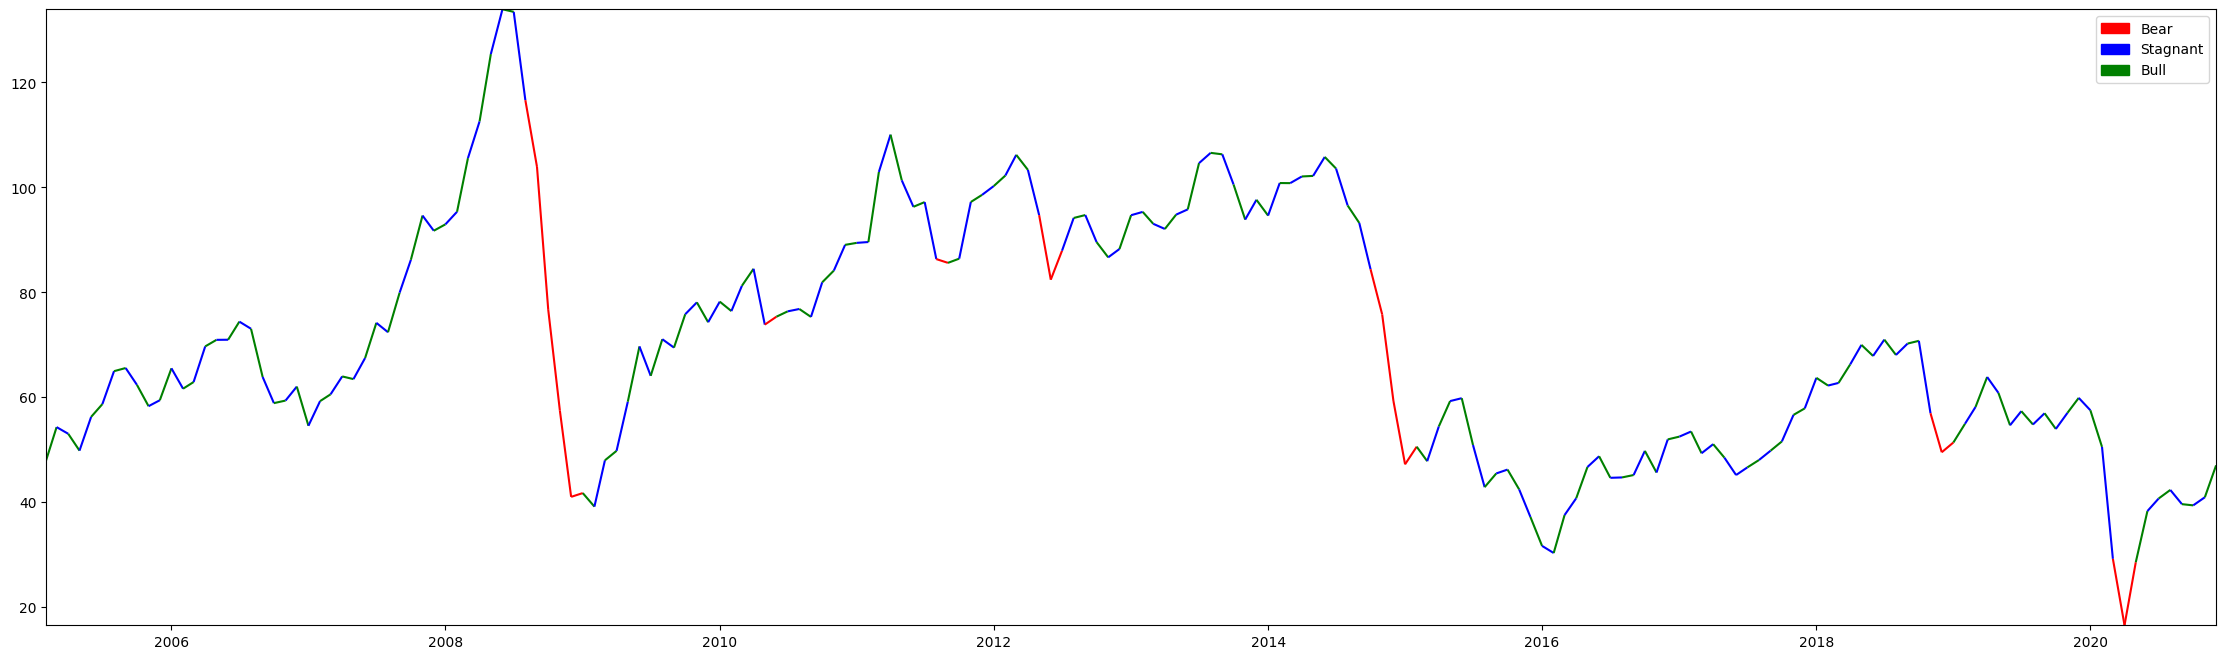

In [8]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from hmmlearn import hmm

# --- 1. Data Preparation ---
price_series = train_data['Oil_Current_Price']
price_diff = price_series.diff()[1:]

# Using only training data
X = np.array(price_diff).reshape(-1, 1)
lenghts = [len(X)]

# =================================================================
# 2. Baum-Welch Algorithm (Training)
# =================================================================

model = hmm.GaussianHMM(
    n_components = 3,
    n_iter = 100,
    random_state = 42,
    verbose = True
)

model.fit(X, lenghts)


# =================================================================
# 3. Viterbi Algorithm (Decoding)
# =================================================================

log_prob, s_seq = model.decode(X, lenghts)



# =================================================================
# 4. MultiColor Time Series Plot (Inspecting Regimes)
# =================================================================

price_plot  = pd.DataFrame(price_series[1:].copy())
price_plot.columns  = ["Crude_Oil"]
price_plot["Regime"] =  s_seq
price_plot["diff"] =  price_diff.values

means_order =  model.means_.flatten().argsort()
map_regimes  =  dict(zip(means_order, [0, 1, 2])) # 0=Bear, 1=Stagnant, 2=Bull
price_plot["Regime"] = price_plot["Regime"].map(map_regimes)

####
print("Generting Multi Color plot for Training Set...")
fig, ax1 =  plt.subplots(figsize =  (28, 8))
cmap  =  ListedColormap(['r', 'b', 'g'], 'indexed')
norm = BoundaryNorm(range(3 + 1), cmap.N)
inxval =  mdates.date2num(price_plot["Crude_Oil"].index.to_pydatetime())
points = np.array([inxval, price_plot["Crude_Oil"]]).T.reshape(-1, 1, 2)
segments =  np.concatenate([points[:-1], points[1:]], axis   = 1)
lc =  LineCollection(segments, cmap =  cmap, norm =  norm)
lc.set_array(price_plot["Regime"])
plt.gca().add_collection(lc)

plt.xlim(price_plot["Crude_Oil"].index.min(), price_plot["Crude_Oil"].index.max())
plt.ylim(price_plot["Crude_Oil"].min(), price_plot["Crude_Oil"].max())

r_patch =  mpatches.Patch(color   =  "red", label =  "Bear")
b_patch =  mpatches.Patch(color =  "blue", label   =  "Stagnant")
g_patch = mpatches.Patch(color   = "green", label =  "Bull")

plt.legend(handles =  [r_patch, b_patch, g_patch])
plt.show()

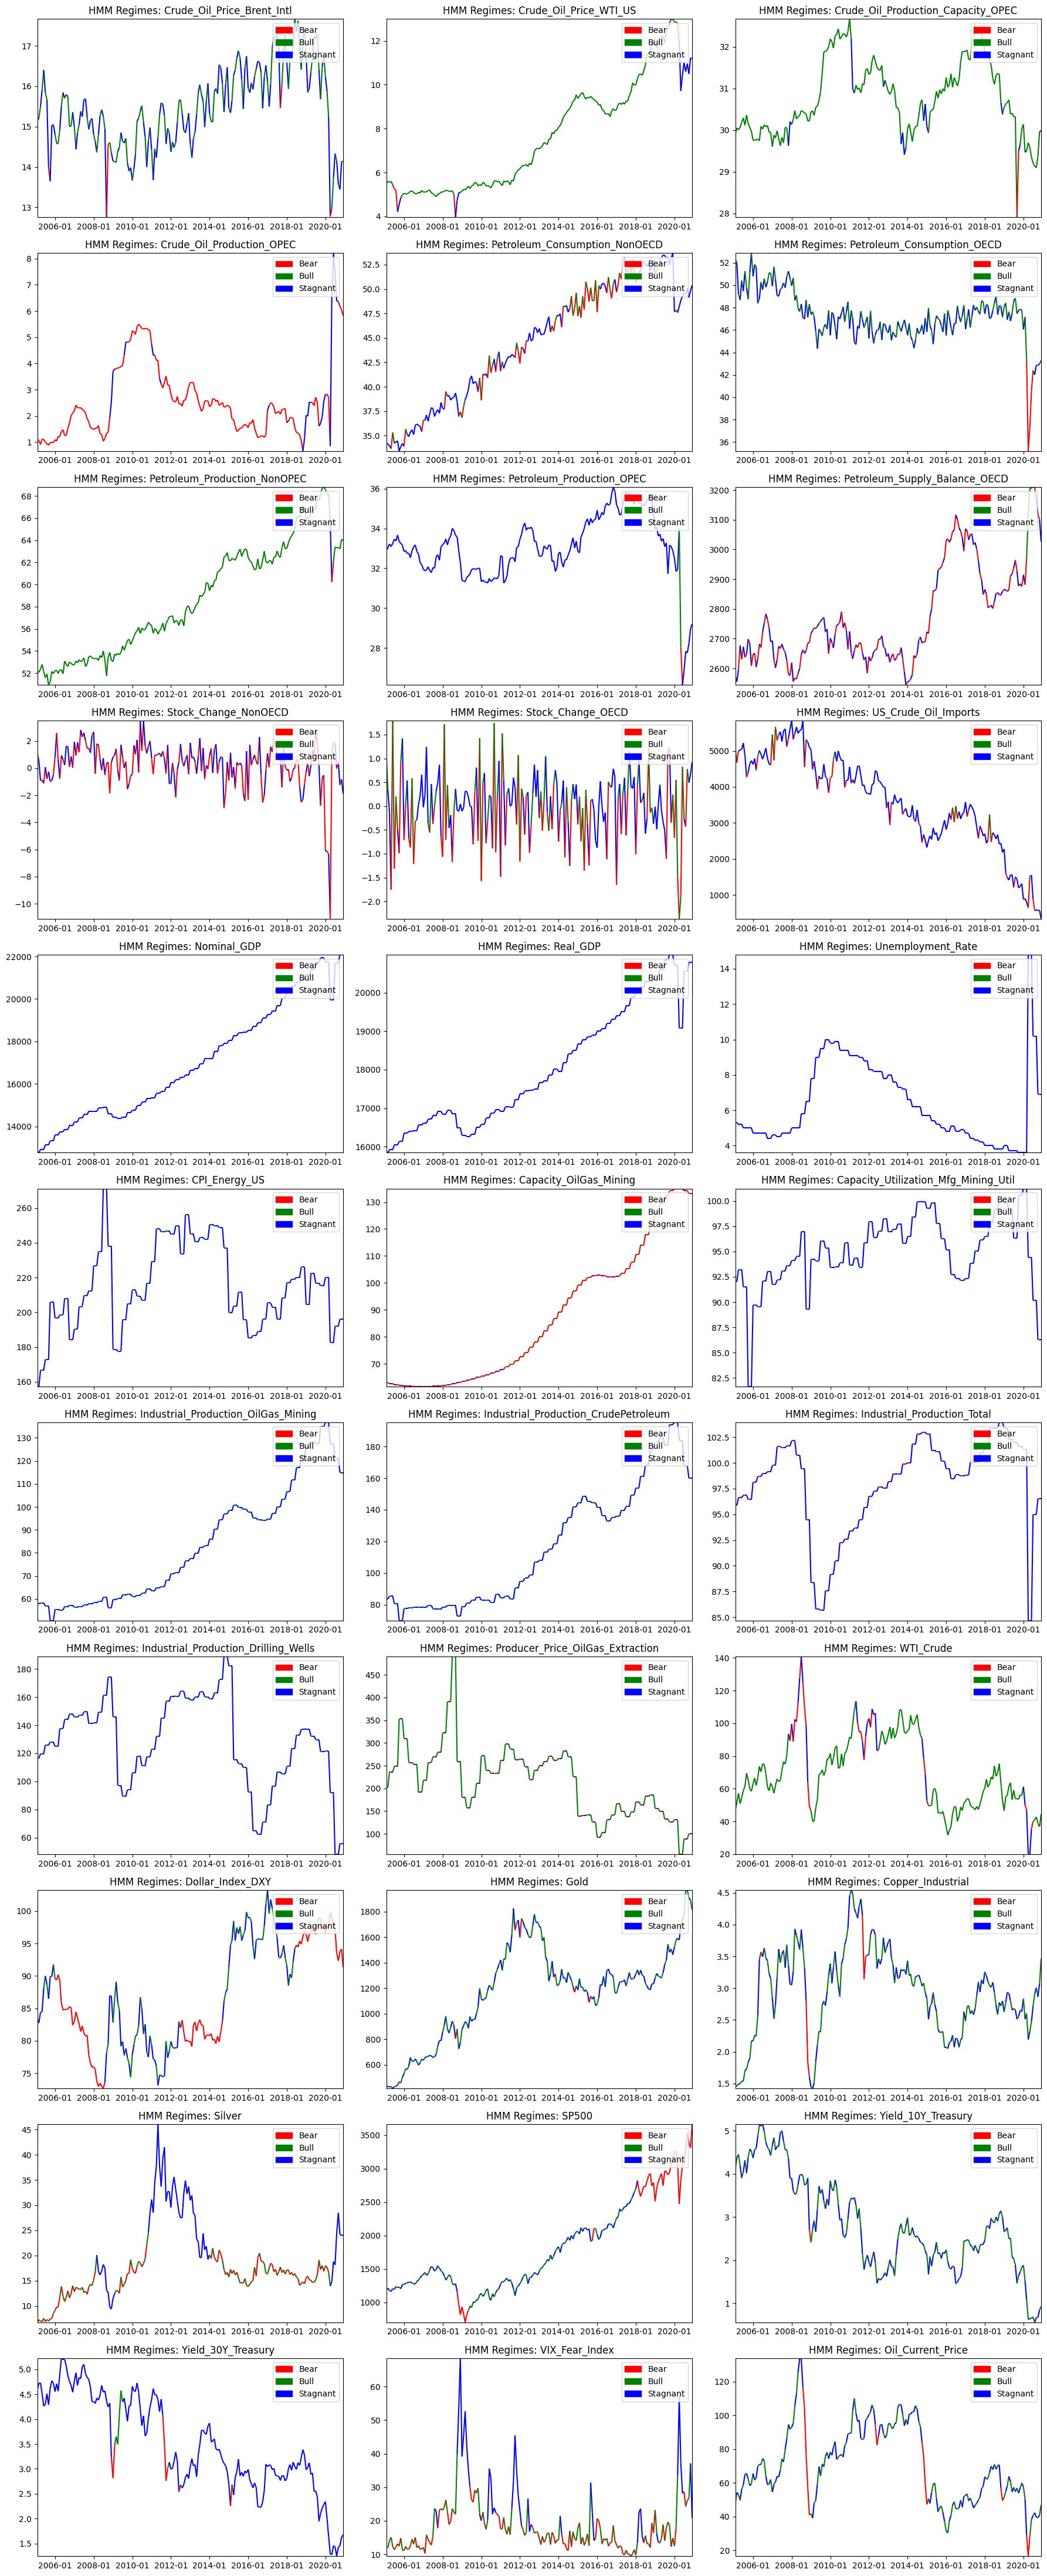

In [9]:
import pandas as pd
import numpy as np
import math
from hmmlearn import hmm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

forecast_column = "Oil_Forecast_Price"
exclude_columns = [forecast_column]


variables = [col for col in train_data.columns if col not in exclude_columns]

states = pd.DataFrame(index=train_data.index[1:])

hmm_models = {}
regime_maps = {}

for var_name in variables:
    price_series = train_data[var_name]
    price_diff = price_series.diff()[1:].fillna(0)
    X = price_diff.values.reshape(-1, 1)

    if len(X) < 1:
        states[var_name] = np.nan
        continue

    # Training  Gaussian HMM
    model = hmm.GaussianHMM(n_components=3, n_iter=100, random_state=42, verbose=False)
    model.fit(X)
    _, s_seq = model.decode(X)

    # Mapping Market Regimes 0=Bear, 1=Stagnant, 2=Bull
    means_order = model.means_.flatten().argsort()
    map_regimes = dict(zip(means_order, [0, 1, 2]))
    mapped_seq = pd.Series(s_seq).map(map_regimes).values
    states[var_name] = mapped_seq

num_vars = len(variables)
cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

cmap = ListedColormap(['r','b','g'],'indexed')
norm = BoundaryNorm(range(4), cmap.N)
r_patch = mpatches.Patch(color='red', label='Bear')
g_patch = mpatches.Patch(color='green', label='Bull')
b_patch = mpatches.Patch(color='blue', label='Stagnant')
handles = [r_patch, g_patch, b_patch]

for i, ax in enumerate(axes):
    if i < num_vars:
        var_name = variables[i]
        price_series = train_data[var_name][1:]
        df = pd.DataFrame(index=price_series.index)
        df["value"] = price_series.values
        df["Regime"] = states[var_name].values

        try:
            inxval = mdates.date2num(df.index.to_pydatetime())
            points = np.array([inxval, df["value"]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(df['Regime'])
            ax.add_collection(lc)
            ax.set_xlim(inxval.min(), inxval.max())
            ax.set_ylim(df["value"].min(), df["value"].max())
            ax.legend(handles=handles)
            ax.set_title(f"HMM Regimes: {var_name}", fontsize=12)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        except Exception as e:
            ax.set_title(f"ERROR {var_name}")
            ax.text(0.5, 0.5, f"Err: {e}", ha='center', va='center', color='red')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

states.index.name = "date"
states.to_csv("hmm_states_matrix_train_set.csv")

# Belief Network Hill Climbing Algorithm

✅ Base structure with 17 edges (Granger test).


  0%|          | 0/1000000 [00:00<?, ?it/s]

✅ Learned model with Hill Climbing + BIC: 34 edges

📊 Nodes and Parents:
  Crude_Oil_Price_Brent_Intl: ['Petroleum_Supply_Balance_OECD', 'SP500']
  Oil_Current_Price: ['Crude_Oil_Price_Brent_Intl']
  US_Crude_Oil_Imports: ['Crude_Oil_Price_Brent_Intl']
  Petroleum_Consumption_NonOECD: ['Dollar_Index_DXY']
  Industrial_Production_CrudePetroleum: ['Petroleum_Consumption_NonOECD']
  Petroleum_Consumption_OECD: ['Stock_Change_NonOECD', 'Dollar_Index_DXY']
  Petroleum_Supply_Balance_OECD: ['Petroleum_Consumption_OECD']
  VIX_Fear_Index: ['Petroleum_Consumption_OECD', 'SP500']
  Petroleum_Production_OPEC: []
  Petroleum_Production_NonOPEC: ['Petroleum_Production_OPEC']
  Stock_Change_NonOECD: ['Gold']
  Nominal_GDP: ['Unemployment_Rate']
  Real_GDP: ['Nominal_GDP']
  Unemployment_Rate: ['Industrial_Production_CrudePetroleum']
  CPI_Energy_US: ['Industrial_Production_OilGas_Mining']
  Producer_Price_OilGas_Extraction: ['CPI_Energy_US']
  Industrial_Production_Drilling_Wells: ['CPI_Energy_US']

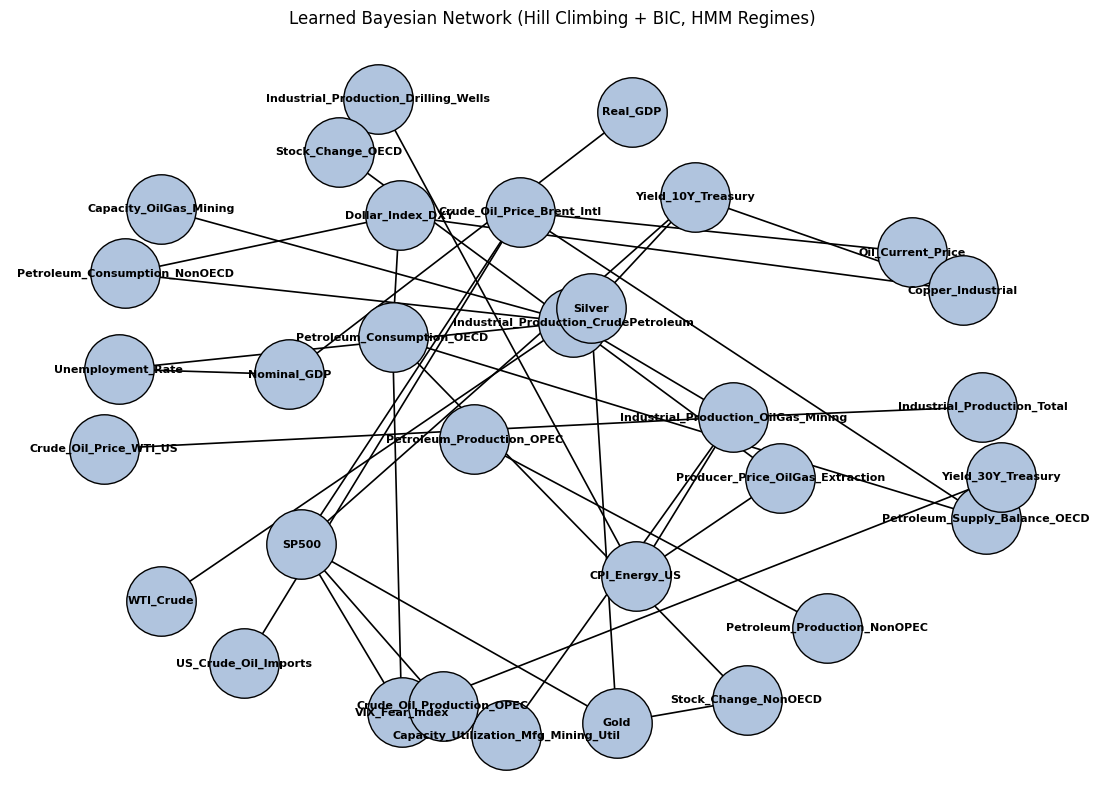

In [10]:
import pandas as pd
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, BIC
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt


states = pd.read_csv("hmm_states_matrix_train_set.csv", index_col="date")
states.columns = [str(col) for col in states.columns]
data_bn = states.copy()

granger_parents = [
    "Crude_Oil_Production_Capacity_OPEC",
    "Petroleum_Consumption_NonOECD",
    "Petroleum_Consumption_OECD",
    "Petroleum_Production_NonOPEC",
    "Petroleum_Production_OPEC",
    "Nominal_GDP",
    "Real_GDP",
    "Unemployment_Rate",
    "CPI_Energy_US",
    "Industrial_Production_OilGas_Mining",
    "Industrial_Production_Total",
    "Industrial_Production_Drilling_Wells",
    "Producer_Price_OilGas_Extraction",
    "WTI_Crude",
    "Dollar_Index_DXY",
    "Copper_Industrial",
    "SP500",
]
target = "Oil_Current_Price"
edges = [(var, target) for var in granger_parents if var in data_bn.columns]
base_model = DiscreteBayesianNetwork(edges)
print(f"✅ Base structure with {len(edges)} edges (Granger test).")

hc = HillClimbSearch(data_bn)
bic = BIC(data_bn)
best_model = hc.estimate(scoring_method=bic)
print(f"✅ Learned model with Hill Climbing + BIC: {len(best_model.edges())} edges")

final_model = DiscreteBayesianNetwork(best_model.edges())
final_model.fit(data_bn, estimator=BayesianEstimator, prior_type="BDeu")

print("\n📊 Nodes and Parents:")
for node in final_model.nodes():
    print(f"  {node}: {final_model.get_parents(node)}")

infer = VariableElimination(final_model)
evidence = {
    "WTI_Crude": 2,
    "Real_GDP": 2,
    "SP500": 1,
    "Dollar_Index_DXY": 0
}
def validate_evidence(model, evidence):
    for var, val in evidence.items():
        estados = list(map(int, model.get_cpds(var).state_names[var]))
        if val not in estados:
            raise ValueError(f"⚠️ {var} only accepts values {estados}, not {val}")
validate_evidence(final_model, evidence)
prediction = infer.query(variables=[target], evidence=evidence)
print(f"\n🔮 Posterior distribution for {target}:")
print(prediction)

plt.figure(figsize=(14, 10))
G = nx.DiGraph()
G.add_nodes_from(final_model.nodes())
G.add_edges_from(final_model.edges())
pos = nx.spring_layout(G, seed=42, k=1.3)
nx.draw_networkx_nodes(G, pos, node_color="lightsteelblue", node_size=2500, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, width=1.2)
plt.title("Learned Bayesian Network (Hill Climbing + BIC, HMM Regimes)", fontsize=12)
plt.axis("off")
plt.show()

## Validation

In [11]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, BIC

forecast_column = "Oil_Forecast_Price"
exclude_columns = [forecast_column]
variables = [col for col in train_data.columns if col not in exclude_columns]

states = pd.DataFrame(index=train_data.index[1:])
hmm_models = {}
regime_maps = {}

for var_name in variables:
    price_series = train_data[var_name]
    price_diff = price_series.diff()[1:].fillna(0)
    X = price_diff.values.reshape(-1, 1)
    if len(X) < 1:
        states[var_name] = np.nan
        continue
    model = hmm.GaussianHMM(n_components=3, n_iter=100, random_state=42, verbose=False)
    model.fit(X)
    _, s_seq = model.decode(X)
    means_order = model.means_.flatten().argsort()
    map_regimes = dict(zip(means_order, [0, 1, 2]))
    mapped_seq = pd.Series(s_seq).map(map_regimes).values
    states[var_name] = mapped_seq
    hmm_models[var_name] = model
    regime_maps[var_name] = map_regimes

states.index.name = "date"
states.to_csv("hmm_states_matrix_train_set.csv")

states = pd.read_csv("hmm_states_matrix_train_set.csv", index_col="date")
states.columns = [str(col) for col in states.columns]
data_bn = states.copy()

granger_parents = [
    "Crude_Oil_Production_Capacity_OPEC",
    "Petroleum_Consumption_NonOECD",
    "Petroleum_Consumption_OECD",
    "Petroleum_Production_NonOPEC",
    "Petroleum_Production_OPEC",
    "Nominal_GDP",
    "Real_GDP",
    "Unemployment_Rate",
    "CPI_Energy_US",
    "Industrial_Production_OilGas_Mining",
    "Industrial_Production_Total",
    "Industrial_Production_Drilling_Wells",
    "Producer_Price_OilGas_Extraction",
    "WTI_Crude",
    "Dollar_Index_DXY",
    "Copper_Industrial",
    "SP500",
]

target = "Oil_Current_Price"
edges = [(var, target) for var in granger_parents if var in data_bn.columns]
base_model = DiscreteBayesianNetwork(edges)

hc = HillClimbSearch(data_bn)
bic = BIC(data_bn)
best_model = hc.estimate(scoring_method=bic)
final_model = DiscreteBayesianNetwork(best_model.edges())
final_model.fit(data_bn, estimator=BayesianEstimator, prior_type="BDeu")

discrete_vald = pd.DataFrame(index=vald_data.index[1:])
for var in data_bn.columns:
    if var in hmm_models and var in regime_maps and var in vald_data.columns:
        price_diff = vald_data[var].diff()[1:].fillna(0).values.reshape(-1, 1)
        _, s_seq = hmm_models[var].decode(price_diff, [len(price_diff)])
        discrete_vald[var] = pd.Series(s_seq).map(regime_maps[var]).values
discrete_vald.index = vald_data.index[1:]

forecast_col = target if target in discrete_vald.columns else 'WTISPLC'
vald_real = discrete_vald[forecast_col].values
vald_data_new = discrete_vald.drop(columns=[forecast_col], errors="ignore")

common_cols = [col for col in vald_data_new.columns if col in final_model.nodes()]
vald_data_new = vald_data_new[common_cols]

vald_prediction = final_model.predict(vald_data_new)
pred_value_vald = vald_prediction[forecast_col].values

print("\nPredicted Value: ")
print(pred_value_vald)
print("\nReal Value: ")
print(vald_real)
error = np.mean(vald_real != np.roll(pred_value_vald, 1))  # Forecast error
print("\nError: ")
print(error * 100)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]


Predicted Value: 
[2 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]

Real Value: 
[1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 0 0 0 2 1 2]

Error: 
78.26086956521739


# Testing

In [12]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, BIC


discrete_test = pd.DataFrame(index=test_data.index[1:])
for var in data_bn.columns:
    if var in hmm_models and var in regime_maps and var in test_data.columns:
        price_diff = test_data[var].diff()[1:].fillna(0).values.reshape(-1, 1)
        _, s_seq = hmm_models[var].decode(price_diff, [len(price_diff)])
        discrete_test[var] = pd.Series(s_seq).map(regime_maps[var]).values
discrete_test.index = test_data.index[1:]

# === 6. TEST INFERENCE AND ERROR CALCULATION ===
test_forecast_col = target if target in discrete_test.columns else 'WTISPLC'
test_real = discrete_test[test_forecast_col].values
test_data_new = discrete_test.drop(columns=[test_forecast_col], errors="ignore")
test_common_cols = [col for col in test_data_new.columns if col in final_model.nodes()]
test_data_new = test_data_new[test_common_cols]

test_prediction = final_model.predict(test_data_new)
pred_value_test = test_prediction[test_forecast_col].values

print("\nPredicted Value (test): ")
print(pred_value_test)
print("\nReal Value (test): ")
print(test_real)
test_error = np.mean(test_real != np.roll(pred_value_test, 1))  # Forecast error
print("\nTest Error: ")
print(test_error * 100)

  0%|          | 0/22 [00:00<?, ?it/s]


Predicted Value (test): 
[2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]

Real Value (test): 
[2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]

Test Error: 
95.65217391304348
